In [1]:
import os
import zipfile
import pathlib
from pathlib import Path
import librosa
import os
from collections import Counter
from pydub import AudioSegment
from pydub.silence import detect_silence
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# Globale Pfade für die Daten
ROOT_DIR = pathlib.Path('../')  # Hauptverzeichnis
ZIP_DIR = ROOT_DIR / 'data'  # Ordner, der die ZIP-Dateien enthält
UNZIP_DIR = ROOT_DIR / 'Unzipped_Data_Picture'  # Zielordner für entpackte Dateien

# #Small Dataset
# TRAIN_DIR = UNZIP_DIR / 'small_train_ds'
# VAL_DIR = UNZIP_DIR / 'small_val_ds'
# TEST_DIR = UNZIP_DIR / 'small_test_ds'

# # Small 3 Labels Dataset
# TRAIN_DIR = UNZIP_DIR / '3_small_train_ds'
# VAL_DIR = UNZIP_DIR / '3_small_val_ds'
# TEST_DIR = UNZIP_DIR / '3_small_test_ds'

# Medium Dataset
TRAIN_DIR = UNZIP_DIR / 'medium_train_ds'
VAL_DIR = UNZIP_DIR / 'medium_val_ds'
TEST_DIR = UNZIP_DIR / 'medium_test_ds'

# # Large Dataset
# TRAIN_DIR = UNZIP_DIR / 'large_train_ds'
# VAL_DIR = UNZIP_DIR / 'large_val_ds'
# TEST_DIR = UNZIP_DIR / 'large_test_ds'

# # Large 3 Labels Dataset
# TRAIN_DIR = UNZIP_DIR / '3_large_train_ds'
# VAL_DIR = UNZIP_DIR / '3_large_val_ds'
# TEST_DIR = UNZIP_DIR / '3_large_test_ds'

# # No_mod Dataset
# TRAIN_DIR = UNZIP_DIR / 'no_mod_train_ds'
# VAL_DIR = UNZIP_DIR / 'no_mod_val_ds'
# TEST_DIR = UNZIP_DIR / 'no_mod_test_ds'


# extract


In [ ]:
def extract_zip(zip_path, extract_to):
    zip_path_str = str(zip_path)
    
    if not zip_path_str.endswith('.zip'):
        zip_path_str += '.zip'
    
    zip_file_path = pathlib.Path(zip_path_str)
    
    folder_name = zip_file_path.stem 
    target_folder = pathlib.Path(extract_to) / folder_name
    
    if target_folder.exists():
        print(f"Das Verzeichnis {target_folder} existiert bereits. Überspringe das Extrahieren.")
    else:
        if zip_file_path.exists():
            print(f"Extrahiere die Zip-Datei {zip_file_path} nach {extract_to}.")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Zip-Datei {zip_file_path} erfolgreich extrahiert.")
        else:
            print(f"Die Zip-Datei {zip_file_path} existiert nicht.")

def rename_audio_files(root_path):
    for root, dirs, files in os.walk(root_path):
        parent_folder = os.path.basename(root)
        for file in files:
            if not file.startswith(f"{parent_folder}_"):
                if file.endswith(('.wav', '.mp3')):  
                    
                    old_file_path = os.path.join(root, file)
                    new_file_name = f"{parent_folder}_{file}"
                    new_file_path = os.path.join(root, new_file_name)
                        
                    os.rename(old_file_path, new_file_path)
        print(f"renaming of {root_path}/{parent_folder} complete")


extract_zip(TRAIN_DIR, UNZIP_DIR)
extract_zip(TEST_DIR, UNZIP_DIR)
extract_zip(VAL_DIR, UNZIP_DIR)
rename_audio_files(UNZIP_DIR)


# split

In [ ]:
def generate_statistics(total_segments, retaining_segments, discarded_segments, trash_dir):
    # Create a bar chart for the statistics
    labels = [f'Total Segments: {total_segments}', f'Valid Segments: {retaining_segments}', f'Discarded Segments: {discarded_segments}']
    values = [total_segments, retaining_segments, discarded_segments]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green', 'red'])
    plt.title('Audio Splitting Statistics')
    plt.ylabel('Count')
    plt.savefig(trash_dir / 'splitting_statistics.png')
    plt.close()

    print(f"Statistics saved as PNG in {trash_dir}")

def contains_completely_silent_part(segment, silence_threshold=-90.0, min_silence_len=100):
    """Check if a segment contains any completely silent part."""
    silence_ranges = detect_silence(
        segment, min_silence_len=min_silence_len, silence_thresh=silence_threshold
    )
    # If any silence range exists that is equal to or exceeds min_silence_len, return True
    return any(end - start >= min_silence_len for start, end in silence_ranges)

def plot_spectrogram(wav_path, output_dir):
    """Plot and save the spectrogram of a wav file."""
    # Load the audio file using librosa (this also returns the sample rate)
    samples, sample_rate = librosa.load(wav_path, sr=None)
    
    # Generate the spectrogram (using a Short-Time Fourier Transform, STFT)
    plt.figure(figsize=(10, 6))
    
    # Compute the spectrogram (logarithmic scale for better visualization)
    D = librosa.amplitude_to_db(librosa.stft(samples), ref=np.max)
    
    # Display the spectrogram
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log', cmap='viridis')
    
    # Add title and labels
    plt.title(f"Spectrogram of {Path(wav_path).name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity (dB)")

    # Save the plot
    spectrogram_path = output_dir / f"{Path(wav_path).stem}_spectrogram.png"
    plt.savefig(spectrogram_path)
    plt.close()

    print(f"Spectrogram saved: {spectrogram_path}")

def split_audio_dataset(input_dir):
        segment_length_ms = 1000
        output_dir = input_dir.parent / f"{input_dir.name}_splits"
        trash_dir = input_dir.parent / f"{input_dir.name}_trash"
        
        if output_dir.exists():
            print(f"Output directory already exists: {output_dir}. Skipping splitting.")
            return output_dir
        
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(trash_dir, exist_ok=True)

        total_segments = 0
        retaining_segments = 0
        discarded_segments = 0

        # Traverse the input directory and split files
        for subdir, _, files in os.walk(input_dir):
            relative_path = Path(subdir).relative_to(input_dir)  # Maintain subdirectory structure
            target_dir = output_dir / relative_path
            os.makedirs(target_dir, exist_ok=True)

            for file in files:
                if file.endswith(".wav"):  # Adjust formats as needed
                    input_path = Path(subdir) / file
                    audio = AudioSegment.from_file(input_path)
                    duration = len(audio)  # Total length of the audio in milliseconds

                    # Split and export segments
                    for i, start_time in enumerate(range(0, duration, segment_length_ms)):
                        end_time = min(start_time + segment_length_ms, duration)
                        segment = audio[start_time:end_time]
                        total_segments +=1
                        file_path = Path(file)  # Convert file string to Path
                        # segment_filename = target_dir / f"{file_path.stem}_segment_{i}.wav"
                        if contains_completely_silent_part(segment):
                            discarded_segments += 1
                            segment_filename = trash_dir / f"{file_path.stem}_segment_{i}.wav"
                            segment.export(segment_filename, format="wav")
                            plot_spectrogram(segment_filename, trash_dir)
                        else:
                            retaining_segments += 1
                            segment_filename = target_dir / f"{file_path.stem}_segment_{i}.wav"
                            segment.export(segment_filename, format="wav")
                            
                    print(f"Processed {file} into {i+1} segments in {target_dir}")

        generate_statistics(total_segments, retaining_segments, discarded_segments, trash_dir)
        print(f"All files processed. Split dataset saved in {output_dir}")
        return output_dir


print(f"Split Audio Data in {1000}ms")
TRAIN_DIR=split_audio_dataset(TRAIN_DIR)
VAL_DIR=split_audio_dataset(VAL_DIR)
TEST_DIR=split_audio_dataset(TEST_DIR)

# Mel-Spektogram

In [ ]:
def generate_mel_spectrograms_with_structure(input_dir, output_dir, n_mels=128, fmin=20, fmax=44100):
    """
    Diese Funktion erzeugt Mel-Spektrogramme für jede Audiodatei im Eingabeverzeichnis, 
    behält die Ordnerstruktur bei und speichert die Spektrogramme im Ausgabeverzeichnis als 128x128-Bilder.

    :param input_dir: Verzeichnis mit den Audiodateien
    :param output_dir: Verzeichnis, in dem die Mel-Spektrogramme gespeichert werden
    :param n_mels: Anzahl der Mel-Bänder
    :param fmin: Minimale Frequenz für Mel-Bänder
    :param fmax: Maximale Frequenz für Mel-Bänder
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    # Überprüfen, ob die Ordnerstruktur bereits existiert
    if output_dir.exists() and any(output_dir.rglob("*.png")):
        print(f"Überspringe Verarbeitung, da {output_dir} bereits Mel-Spektrogramme enthält.")
        return

    # Durchlaufe alle .wav-Dateien im input_dir
    for audio_file in input_dir.rglob("*.wav"):
        # Relativer Pfad zur Eingabedatei
        relative_path = audio_file.relative_to(input_dir)
        
        # Zielpfad basierend auf der ursprünglichen Ordnerstruktur
        target_dir = output_dir / relative_path.parent
        target_dir.mkdir(parents=True, exist_ok=True)

        # Zielpfad für das Mel-Spektrogramm
        mel_spectrogram_path = target_dir / f"{audio_file.stem}_mel_spectrogram.png"

        # Lade die Audiodatei mit librosa
        y, sr = librosa.load(audio_file, sr=None)

        # Berechne das Mel-Spektrogramm
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)

        # Konvertiere das Mel-Spektrogramm in dB (logarithmische Skala)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Erstelle das Bild des Mel-Spektrogramms
        plt.figure(figsize=(2, 2))  # Kleinere Größe für 128x128
        librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
        plt.axis('off')  # Keine Achsen anzeigen

        # Speichere das Bild als PNG
        plt.savefig(mel_spectrogram_path, bbox_inches='tight', pad_inches=0, dpi=300)

        # Schließe die Abbildung
        plt.close()

        print(f"Mel-Spektrogramm für {audio_file.name} gespeichert in {mel_spectrogram_path}")

    print(f"Alle Mel-Spektrogramme gespeichert in {output_dir}")

# Beispielaufruf:
train_mel_dir = Path("train_ds_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
generate_mel_spectrograms_with_structure(TRAIN_DIR, train_mel_dir)

val_mel_dir = Path("val_ds_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
generate_mel_spectrograms_with_structure(VAL_DIR, val_mel_dir)

test_mel_dir = Path("test_ds_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
generate_mel_spectrograms_with_structure(TEST_DIR, test_mel_dir)


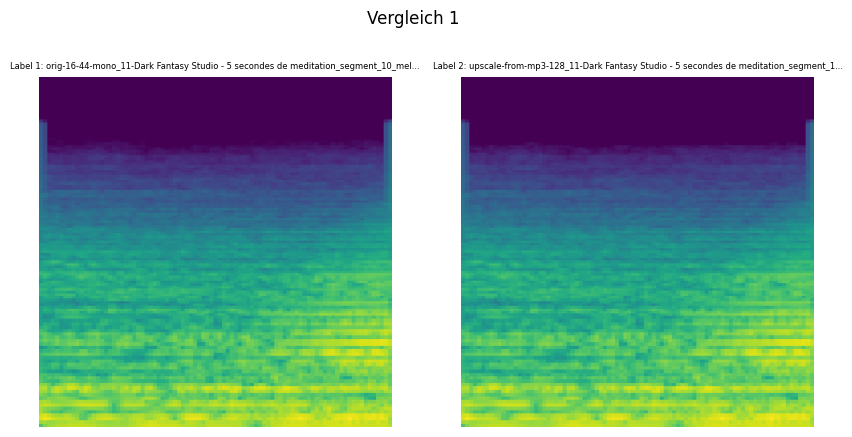

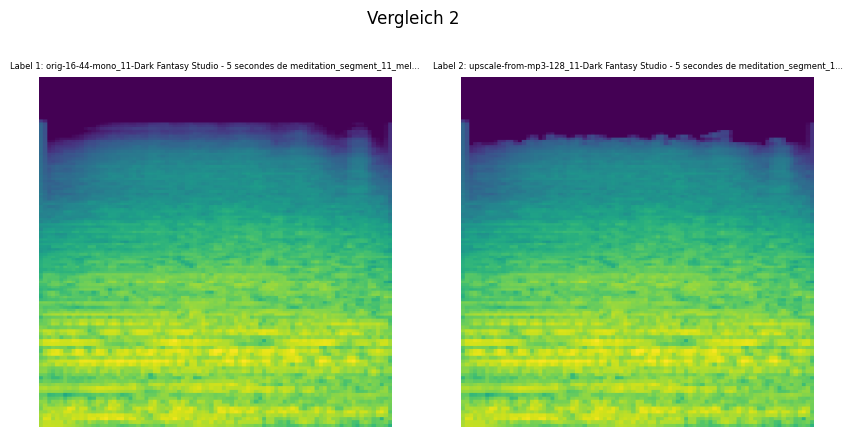

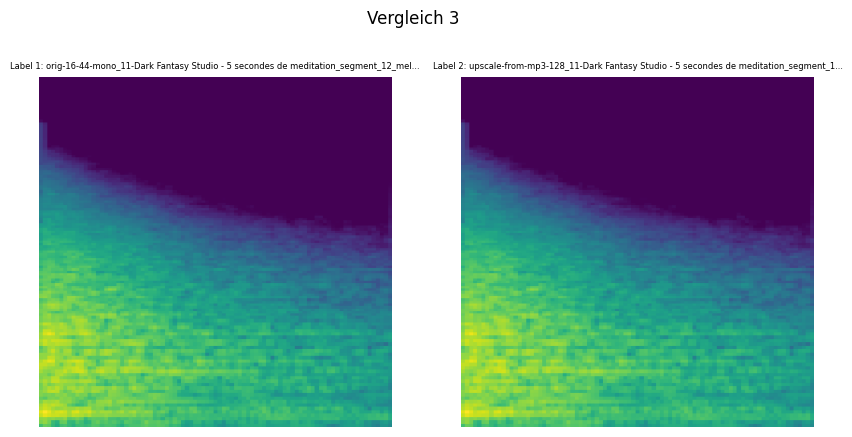

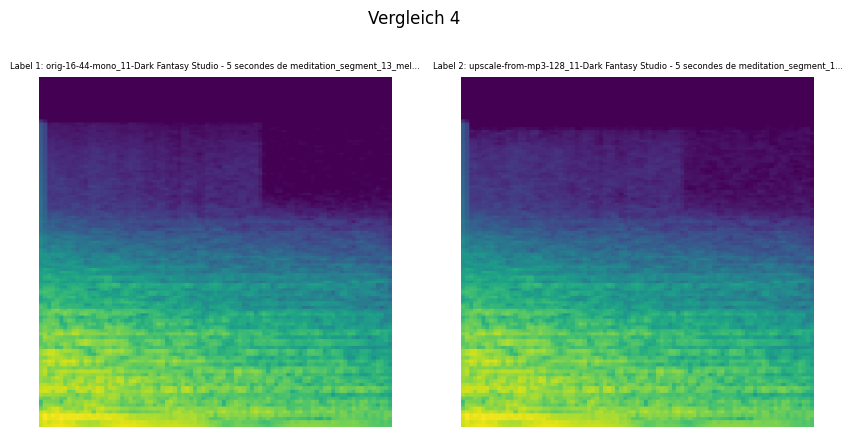

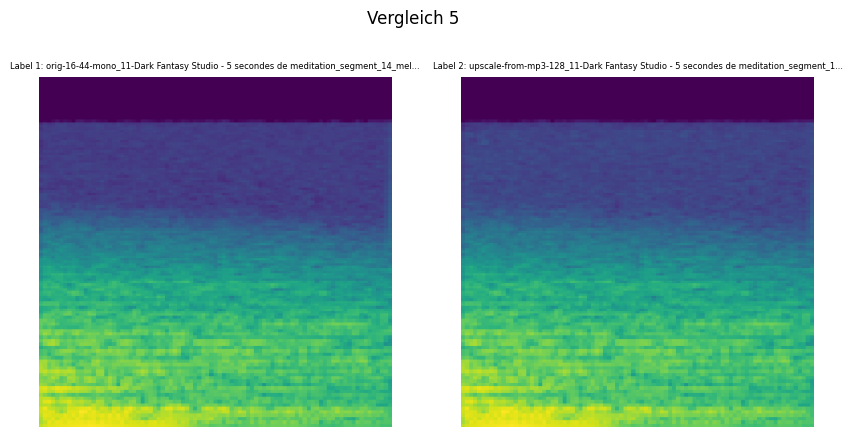

In [9]:
def compare_segments(output_dir):
    """
    Diese Funktion vergleicht Mel-Spektrogramme aus zwei verschiedenen Label-Unterordnern, 
    indem sie die ersten fünf Dateien paarweise nach ihrem Index abgleicht und als Grafik anzeigt.

    :param output_dir: Verzeichnis, das die Label-Unterordner mit Mel-Spektrogrammen enthält
    """
    output_dir = Path(output_dir)
    label_dirs = [d for d in output_dir.iterdir() if d.is_dir()]

    if len(label_dirs) < 2:
        raise ValueError("Es müssen mindestens zwei Label-Unterordner vorhanden sein.")

    # Sortiere die Label-Unterordner alphabetisch
    label_dirs.sort()

    # Liste der Dateien in jedem Label-Unterordner
    files_per_label = [sorted(label_dir.glob("*.png")) for label_dir in label_dirs]

    # Paare von Dateien basierend auf ihrem Index erstellen (maximal 5 Paare)
    pairs = list(zip(*files_per_label))[:5]

    # Vergleiche und zeige die Paare als Grafik an
    for idx, (file1, file2) in enumerate(pairs):
        img1 = plt.imread(file1)
        img2 = plt.imread(file2)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(f"Label 1: {file1.stem[:80]}...", fontsize=6)  # Verkürzt und kleinere Schriftgröße
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(f"Label 2: {file2.stem[:80]}...", fontsize=6)  # Verkürzt und kleinere Schriftgröße
        plt.axis('off')

        plt.suptitle(f"Vergleich {idx + 1}")
        plt.show()

    
compare_segments(train_mel_dir)
